### Modeling Cyanobacteria Blooms in Lake Champlain

To do:

Data cleaning and exploration:
- get data with:
    - rows with missing cyanobac removed
    - missing values removed or replaced with monthly averages
    - month and N:P and target columns added
    - target +1timestep added
- look at histogram/distribution of cyanobac values

Try each of the following:
- linear regression - MC
- logistic regression - TL
- SVM with various kernels -TL
- random forest - MC

Also look at:
- look at the data with PCA?
- use a feature importance function from sci kit learn to look at that...?

In [80]:
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

from sklearn import decomposition #for PCA


In [81]:
#Load data
path = os.getcwd() + '/data/AllSites.csv'
ds1 = pd.read_csv(path)

#Remove rows with missing cyanobacteria values
ds1 = ds1.dropna(axis=0, subset = ['NP_Cya_bio'])

#Remove rows with any missing value? We can do this for individual analyses depending what we're doing.
#ds1 = ds1.dropna(axis=0, how='any')

#Add target column
ds1['target'] = [1 if x >= 4e8 else 0 for x in ds1['NP_Cya_bio']]

print(ds1.shape)
print(type(ds1))
print(ds1[ds1['target'] == 1])


(1431, 15)
<class 'pandas.core.frame.DataFrame'>
      StationID                 Station      Date    Time Stratum Depth  \
936           9     Otter Creek Segment  08/18/11  1235.0       E   4.6   
940           9     Otter Creek Segment  09/02/11  1140.0       E     3   
3037         40          St. Albans Bay  08/06/14  1210.0       U   2.2   
3038         40          St. Albans Bay  08/19/14  1010.0       U   2.6   
3269         50          Missisquoi Bay  09/22/06  1100.0       U   2.2   
3271         50          Missisquoi Bay  10/06/06  1100.0       U   2.6   
3307         50          Missisquoi Bay  08/20/08  1050.0       U     2   
3400         50          Missisquoi Bay  07/30/13  1020.0       U     3   
3461         51  Missisquoi Bay Central  09/07/06  1055.0       U   2.4   
3464         51  Missisquoi Bay Central  09/22/06  1040.0       U     2   
3499         51  Missisquoi Bay Central  08/06/08  1115.0       U     2   
3556         51  Missisquoi Bay Central  08/12/11  

Text(0, 0.5, 'Frequency')

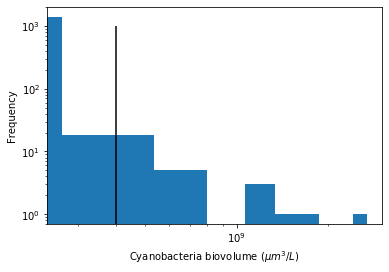

In [82]:
#Make a histogram to look at distribution of cyanobacteria biovolumes
plt.hist(ds1['NP_Cya_bio'], bins = 10)
plt.xscale('log')
plt.yscale('log')
plt.vlines(4e8, 0, 1e3)
plt.xlabel('Cyanobacteria biovolume ($\mu m^3/L$)')
plt.ylabel('Frequency')

In [83]:
#Create cleaned dataframe, ds2:
ds2 = ds1.drop(['StationID', 'Station', 'Date', 'Time', 'Stratum', 'Depth', 'target'], axis=1)

#Use regex to remove 'H's and 'J's
ds2['Month'] = ds1['Date'].astype(str).str.extract('(\d\d)').astype(int) # This is just the month number
ds2['TP'] = ds1['TP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['DP'] = ds1['DP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Cl'] = ds1['Cl'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TN'] = ds1['TN'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TempC'] = ds1['TempC'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Chla'] = ds1['Chla'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Secchi'] = ds1['Secchi'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['N:P'] = ((ds2['TN']*1e-3)/14.007)/((ds2['TP']*1e-6)/30.974) #for TN in ds2['TN'] for TP in ds2['TP']]
ds2['Target'] = [1 if x >= 4e8 else 0 for x in ds1['NP_Cya_bio']]
ds2

,TP,DP,Cl,TN,TempC,Chla,Secchi,NP_Cya_bio,Month,N:P,Target
0,39.2,16.2,13.0,0.61,NaN,1.41,0.5,0.0,4,34.410892,0
1,36.8,14.8,17.5,0.45,13.7,9.67,1.1,0.0,5,27.040633,0
2,50.1,27.4,12.1,0.55,14.5,2.04,0.7,0.0,5,24.276000,0
4,59.6,32.6,12.0,0.65,17.7,4.13,0.6,0.0,6,24.116777,0
5,77.3,47.9,10.5,0.62,22.5,1.74,0.6,0.0,6,17.736355,0
...,...,...,...,...,...,...,...,...,...,...,...
3629,53.4,16.8,8.0,0.69,25.6,27.50,1.1,389000000.0,8,28.573274,0
3631,83.4,33.9,8.3,0.71,23.7,23.94,1.0,133000000.0,9,18.825411,0
3632,94.2,40.7,8.7,0.90,22.3,50.16,1.0,443000000.0,9,21.127289,1
3634,68.8,42.6,9.6,0.74,13.4,10.22,1.4,9460000.0,10,23.784578,0


In [84]:
#Drop cyanobac biovolumes - or not, depending what we're doing
#ds2 = ds2.drop(['NP_Cya_bio'], axis=1)

#Assign X and y
#X = np.array(ds2.drop(['Target'], axis=1))
#y = np.array(ds2['Target'])

#print((ds2))
#print(ds2[ds2['Target'] == 1])

#print(type(X))
#print(type(y))

(1298, 9)
[0.75564308 0.14400889 0.0424884 ]
0.9421403715442501


Text(0, 0.5, 'X2')

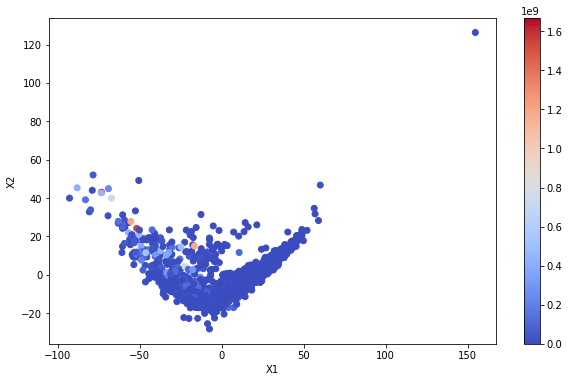

In [85]:
#PCA!

#Drop all NAs:
ds2 = ds2.dropna(axis=0, how='any')

#Drop cyanobac biovolume and labels for X:
X = np.array(ds2.drop(['Target', 'NP_Cya_bio'], axis=1))
print(X.shape)

#PCA - never scale the data for PCA. And we don't need to center it because sklearn does this automatically.
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

#Eigenvalues:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_)) 
#The first two components explain 90% of the variance!
#The first three components explain 94% of variance!

#2D Plot
fig, ax = plt.subplots(figsize=(10,6))
scatter_plot = ax.scatter(X_pca[:,0], X_pca[:,1], c=np.array(ds2['NP_Cya_bio']), cmap=plt.cm.coolwarm)
fig.colorbar(scatter_plot, ax=ax )
ax.set_xlabel('X1')
ax.set_ylabel('X2')

#3D Plot
